In [1]:
import pandas as pd
from pandas import datetime
from pandas import DataFrame

from matplotlib import pyplot

from math import sqrt
from numpy import concatenate
from pandas import concat

from sklearn.preprocessing import MinMaxScaler


from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

C:\ProgramData\Anaconda3\envs\Forecatsing\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
# dataset indonesia (jakarta)
case = pd.read_csv('data/new/case_maret_july.csv')
mobility = pd.read_csv('data/new/mobility_maret_july.csv')
weather = pd.read_csv('data/new/weather_maret_july.csv')
case.set_index('date', inplace=True)
#weather.set_index('date', inplace=True)
mobility.set_index('date', inplace=True)

In [4]:
new_weather = weather.interpolate(method='spline', order=2)
new_weather.head()

new_weather.set_index('date', inplace=True)

In [5]:
data = pd.concat([case, new_weather, mobility], axis=1)
data.head()

,case,rh,avt,mxt,mnt,retail_recreation,grocery_pahrmacy,parks,transit_station,workplace,residential
date,,,,,,,,,,,
2020-03-18,38,86.0,27.6,29.0,25.800000,-22,-3,-28,-32,-19,11
2020-03-19,50,83.0,28.1,31.4,25.800000,-28,-12,-33,-38,-21,12
2020-03-20,14,82.0,27.4,31.2,25.200000,-30,-11,-32,-42,-23,15
2020-03-21,44,81.0,28.1,32.4,26.521978,-35,-5,-38,-40,-10,11
2020-03-22,36,84.0,27.2,31.2,25.000000,-49,-22,-59,-49,-12,14


In [6]:
values = data.values
# ensure all data is float
values = values.astype('float32')

In [7]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled)

[[0.00571565 0.7428571  0.40983582 ... 0.7704917  0.8428571  0.28125   ]
 [0.00857347 0.65714276 0.49180317 ... 0.67213106 0.8142857  0.3125    ]
 [0.         0.6285714  0.37704897 ... 0.6065573  0.78571427 0.40625   ]
 ...
 [0.15289356 0.39999998 0.8196721  ... 0.54098356 0.15714282 0.46875   ]
 [0.18361516 0.45714295 0.73770475 ... 0.3770491  0.04285717 0.3125    ]
 [0.1471779  0.31428564 0.7704916  ... 0.409836   0.02857137 0.4375    ]]


In [8]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed)

     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1     0.005716   0.742857   0.409836      0.175   0.560000   0.821429   
2     0.008573   0.657143   0.491803      0.475   0.560000   0.714286   
3     0.000000   0.628571   0.377049      0.450   0.440001   0.678571   
4     0.007145   0.600000   0.491803      0.600   0.704396   0.589286   
5     0.005239   0.685714   0.344262      0.450   0.400000   0.339286   
..         ...        ...        ...        ...        ...        ...   
418   0.189331   0.571429   0.540984      0.600   0.320000   0.928571   
419   0.161943   0.457143   0.754098      0.750   0.480000   1.000000   
420   0.093356   0.371429   0.786885      0.900   0.520000   0.964286   
421   0.152894   0.400000   0.819672      0.775   0.840000   0.839286   
422   0.183615   0.457143   0.737705      0.750   0.840000   0.607143   

     var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...   var2(t)   var3(t)  \
1     0.651515   0.944444   0.770492    0.8428

In [9]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[12,13,14,15,16,17,18,19,20,21]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.005716   0.742857   0.409836      0.175   0.560000   0.821429   
2   0.008573   0.657143   0.491803      0.475   0.560000   0.714286   
3   0.000000   0.628571   0.377049      0.450   0.440001   0.678571   
4   0.007145   0.600000   0.491803      0.600   0.704396   0.589286   
5   0.005239   0.685714   0.344262      0.450   0.400000   0.339286   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)   var1(t)  
1   0.651515   0.944444   0.770492    0.842857     0.28125  0.008573  
2   0.515152   0.875000   0.672131    0.814286     0.31250  0.000000  
3   0.530303   0.888889   0.606557    0.785714     0.40625  0.007145  
4   0.621212   0.805556   0.639344    0.971429     0.28125  0.005239  
5   0.363636   0.513889   0.491803    0.942857     0.37500  0.008812  


In [10]:
# split into train and test sets
values = reframed.values

n_total = round((values.shape[0])*80/100)


train = values[:n_total, :]
test = values[n_total:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(338, 1, 11) (338,) (84, 1, 11) (84,)


In [11]:
train_X.shape[1]

1

In [12]:
train_X.shape[2]

11

Epoch 1/100
68/68 - 1s - loss: 0.0952 - val_loss: 0.1660
Epoch 2/100
68/68 - 0s - loss: 0.1589 - val_loss: 0.2560
Epoch 3/100
68/68 - 0s - loss: 0.1668 - val_loss: 0.2450
Epoch 4/100
68/68 - 0s - loss: 0.1362 - val_loss: 0.1989
Epoch 5/100
68/68 - 0s - loss: 0.1010 - val_loss: 0.1877
Epoch 6/100
68/68 - 0s - loss: 0.0947 - val_loss: 0.1771
Epoch 7/100
68/68 - 0s - loss: 0.0896 - val_loss: 0.1508
Epoch 8/100
68/68 - 0s - loss: 0.0756 - val_loss: 0.1416
Epoch 9/100
68/68 - 0s - loss: 0.0646 - val_loss: 0.1241
Epoch 10/100
68/68 - 0s - loss: 0.0587 - val_loss: 0.1121
Epoch 11/100
68/68 - 0s - loss: 0.0540 - val_loss: 0.0980
Epoch 12/100
68/68 - 0s - loss: 0.0507 - val_loss: 0.0897
Epoch 13/100
68/68 - 0s - loss: 0.0462 - val_loss: 0.0941
Epoch 14/100
68/68 - 0s - loss: 0.0470 - val_loss: 0.0971
Epoch 15/100
68/68 - 0s - loss: 0.0454 - val_loss: 0.0974
Epoch 16/100
68/68 - 0s - loss: 0.0443 - val_loss: 0.0920
Epoch 17/100
68/68 - 0s - loss: 0.0425 - val_loss: 0.0992
Epoch 18/100
68/68 - 0s

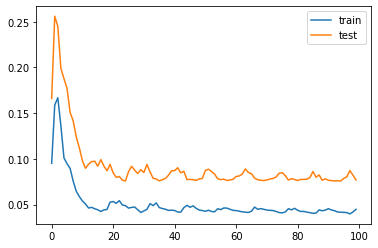

In [13]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=5, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [14]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 444.804
